# UMedia Contents Tutorial Guide

This tutorial guide contains explanations on every folder within the 05a-01_umedia folder and what the 1) contents are, 2) how they operate and 3) where they are posted after they run with the `harvest.py` script.
> Original created on Feb 5, 2023 by Alexander Danielson (ardumn)

# harvest.py

> The UMedia harvest script aims to find the newly added map items in a specific date range.
Users need to input a starting date in a YYYY-MM format, and the ending date will be current
date by default. Besides, users need also input the expected number of search results so that
at the beginning of the execution.

> A temporary JSON file 'request_YYYYMMDD.json' wll be updated and saved for all search results.
Then it will be split and saved into 'jsons' folder by month within the expected date range.
CSV files in the 'reports' folder are the metadata extracted by thier jsons by month.


In [ ]:
import json
import time
import csv
import urllib.request
import pandas as pd

In [ ]:
# user input 1: number of map search results
num = input('Enter the number of latest maps: ')
# assertion to check input format
assert num.isdigit() == True, 'Input number must be a integer.'

In [ ]:
# user input 2: set date range for search
dateBegin = input('Set a date range from an input YYYY-MM to today: ')
# assertions to check input format: YYYY-MM
assert dateBegin.count('-') == 1, 'Input format must be a dash-separated pair of year and month. '
assert len(dateBegin.split('-')[0]) == 4, 'Input year must be 4 digits.'
assert len(dateBegin.split('-')[1]) == 2, 'Input year must be 2 digits.'

In [ ]:
dateEnd = time.strftime('%Y-%m')
months = pd.date_range(dateBegin, dateEnd,freq='M').strftime("%Y-%m").tolist()
if dateEnd not in months:
    months.append(dateEnd)

fieldnames = ['Title', 'Alternative Title', 'Description', 'notes', 'dimensions', 'scale', 'Language', 'Creator', 'Publisher',
              'Resource Type', 'Keyword', 'Date Issued', 'Temporal Coverage', 'Date Range',
              'Information', 'Download', 'Image', 'Manifest', 
              'Identifier', 'ID', 'Access Rights', 'Provider', 'Code', 'Is Part Of', 'Member Of',
              'Accrual Method', 'Date Accessioned', 'Rights', 'Resource Class', 'Format', 'Date Added', 'Collection Name', 'Set', 'City', 'State', 'Country', 'Continent', 'Region', 'coordinates'] 

actionDate = time.strftime('%Y-%m-%d')

In [ ]:
# requested maps are sorted by latest added with the specific search numbers
req = f'https://umedia.lib.umn.edu/search.json?facets%5Bcontributing_organization_name_s%5D%5B%5D=University+of+Minnesota+Libraries%2C+John+R.+Borchert+Map+Library.&q=borchert&rows={num}&sort=date_added_sort+desc%2C+title_sort+asc'
print('> Requesting URL ...')
res = urllib.request.urlopen(req)
print('> Loading data ...')
data = json.loads(res.read())

# store all search results in the temporary JSON file
datapath = 'requests/request_{}{}{}.json'.format(actionDate.split('-')[0],actionDate.split('-')[1],actionDate.split('-')[2])
with open(datapath, 'w') as fw:
    json.dump(data, fw)
with open(datapath) as fr:
    data = json.load(fr)

In [ ]:
# split and store JSON search results by month
print('> Searching maps added from {} to {} ...'.format(dateBegin, dateEnd))
searchResult = {}
for month in months:
    maps = [x for x in data if x["date_added"].startswith(month)]
    if maps:
        print()
        print('> Found {} maps added on {}'.format(len(maps), month))
        searchResult[month] = len(maps)
        jsonpath = 'jsons/dateAdded_{}{}.json'.format(month.split('-')[0],month.split('-')[1])
        with open(jsonpath, 'w') as f:
            print('> Saving JSON locally ...')
            jsonObj = json.dumps(maps)
            f.write(jsonObj)

            # create metadata by month
            print('> Preparing Metadata ...')
            full_df = pd.read_json(jsonpath)
            full_df = full_df.fillna('')
            out_df = pd.DataFrame(columns=fieldnames)

            ## extract content from full_df
            out_df['Title'] = full_df['title']
            out_df['Alternative Title'] = full_df['title']
            
            
            try:
                  out_df['Description'] = full_df['description']
            except:
                  out_df['Description'] = ''

            try:
                  out_df['Creator'] = full_df['creator'].str.join('|')
            except:
                  out_df['Creator'] = ''
                  
            try:
                  out_df['notes'] = full_df['notes']
            except:
                  out_df['notes'] = ''

            try:
                  out_df['dimensions'] = full_df['dimensions']
            except:
                  out_df['dimensions'] = ''

            try:
                  out_df['scale'] = full_df['scale']
            except:
                  out_df['scale'] = '' 

            try:
                  out_df['coordinates'] = full_df['coordinates'].str.join('|')
            except:
                  out_df['coordinates'] = ''   

            try:
                  out_df['Collection Name'] = full_df['collection_name']
            except:
                  out_df['Collection Name'] = '' 

            try:
                  out_df['Set'] = full_df['set_spec']
            except:
                  out_df['Set'] = ''   
            
            out_df['Language'] = full_df['language'].str.join('|')
            out_df['Publisher'] = full_df['publisher']
            out_df['Keyword'] = full_df['subject'].str.join('|')
            out_df['Date Issued'] = full_df['date_created'].str.join('')

            ## spatial coverage
            try:
                  out_df['City'] = full_df['city'].str.join('|')
            except:
                  out_df['City'] = ''   
            
            try:
                  out_df['State'] = full_df['state'].str.join('|')
            except:
                  out_df['State'] = ''   

            try:
                  out_df['Country'] = full_df['country'].str.join('|')
            except:
                  out_df['Country'] = '' 
                  
            try:
                  out_df['Continent'] = full_df['continent'].str.join('|')
            except:
                  out_df['Continent'] = ''   

            try:
                  out_df['Region'] = full_df['region'].str.join('|')
            except:
                  out_df['Region'] = ''   
                  
            try:
                  out_df['Rights'] = full_df['local_rights'].str.join('|')
            except:
                  out_df['Rights'] = ''   
                  
            try:
                  out_df['Identifier'] = full_df['system_identifier'].str.join('|')
            except:
                  out_df['Identifier'] = '' 

            out_df['Information'] = 'https://umedia.lib.umn.edu/item/' + full_df['id']
            out_df['Download'] = 'http://cdm16022.contentdm.oclc.org/utils/getfile/collection/' + full_df['set_spec'] + '/id/' + full_df['parent_id'].astype(str) + '/filename/print/page/download/fparams/forcedownload'
            out_df['Image'] = full_df['thumb_url']
            out_df['Manifest'] = 'https://cdm16022.contentdm.oclc.org/iiif/info/' + full_df['set_spec'] + '/' + full_df['parent_id'].astype(str) + '/manifest.json'
            out_df['ID'] = full_df['id']
            out_df['Date Added'] = full_df['date_added']


            ## some hard-code fields
            out_df['Resource Type'] = ''
            out_df['Provider'] = 'University of Minnesota'
            out_df['Code'] = '05d-01'
            out_df['Is Part Of'] = '05d-01'
            out_df['Member Of'] = '64bd8c4c-8e60-4956-b43d-bdc3f93db488'
            out_df['Accrual Method'] = 'JSON API'
            out_df['Access Rights'] = 'Public'
            out_df['Date Accessioned'] = actionDate
            out_df['Resource Class'] = 'Maps'
            out_df['Format'] = 'JPEG'


            csvpath = "reports/dateAdded_{}{}.csv".format(month.split('-')[0],month.split('-')[1])
            out_df.to_csv(csvpath, index=False)
            print("> CSV report is created")

print()
print()
print('----------- Search Results -----------')
for m in searchResult:
    print('{} maps added on {}'.format(searchResult[m], m))


### allRawHarvest_2017-2022.csv
> https://github.com/geobtaa/workflows/blob/main/harvesting/05a-01_umedia/allRawHarvest_2017-2022.csv

Screen Shot 2023-02-05 at 14.58.56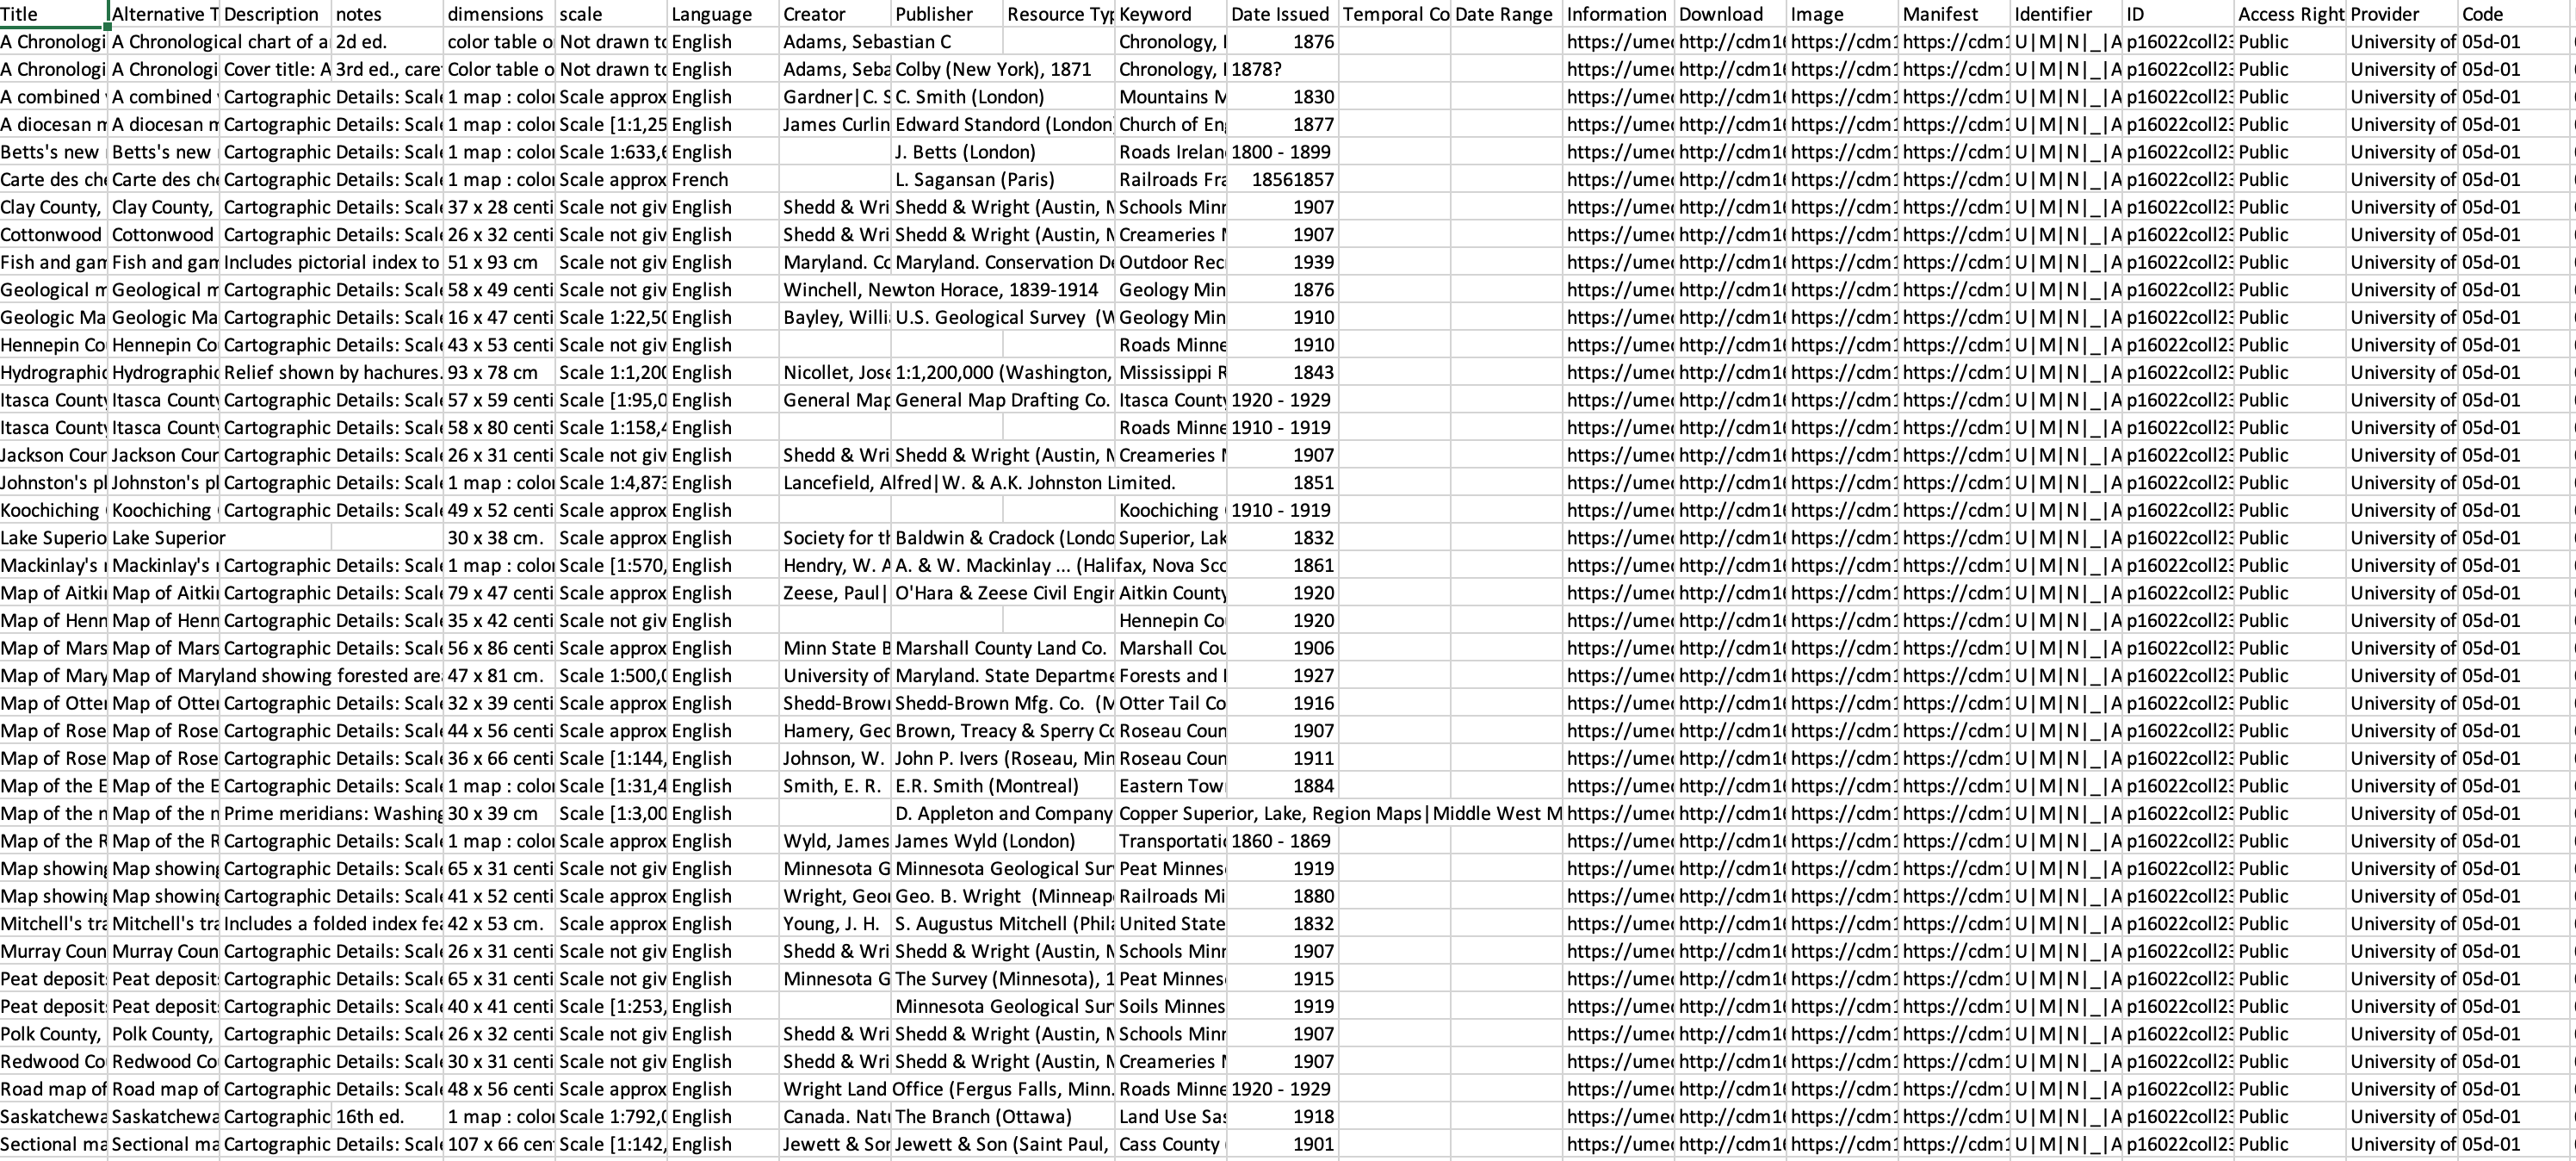

allRawHarvest_2017-2022.csv is a comprehensive CSV with all UMedia records that are hosted on the UMedia website.

### bbox_lookup.csv and bbox_lookup_2.csv

> https://github.com/geobtaa/workflows/blob/main/harvesting/05a-01_umedia/bbox_lookup.csv
> https://github.com/geobtaa/workflows/blob/main/harvesting/05a-01_umedia/bbox_lookup_2.csv

Screen Shot 2023-02-06 at 16.51.52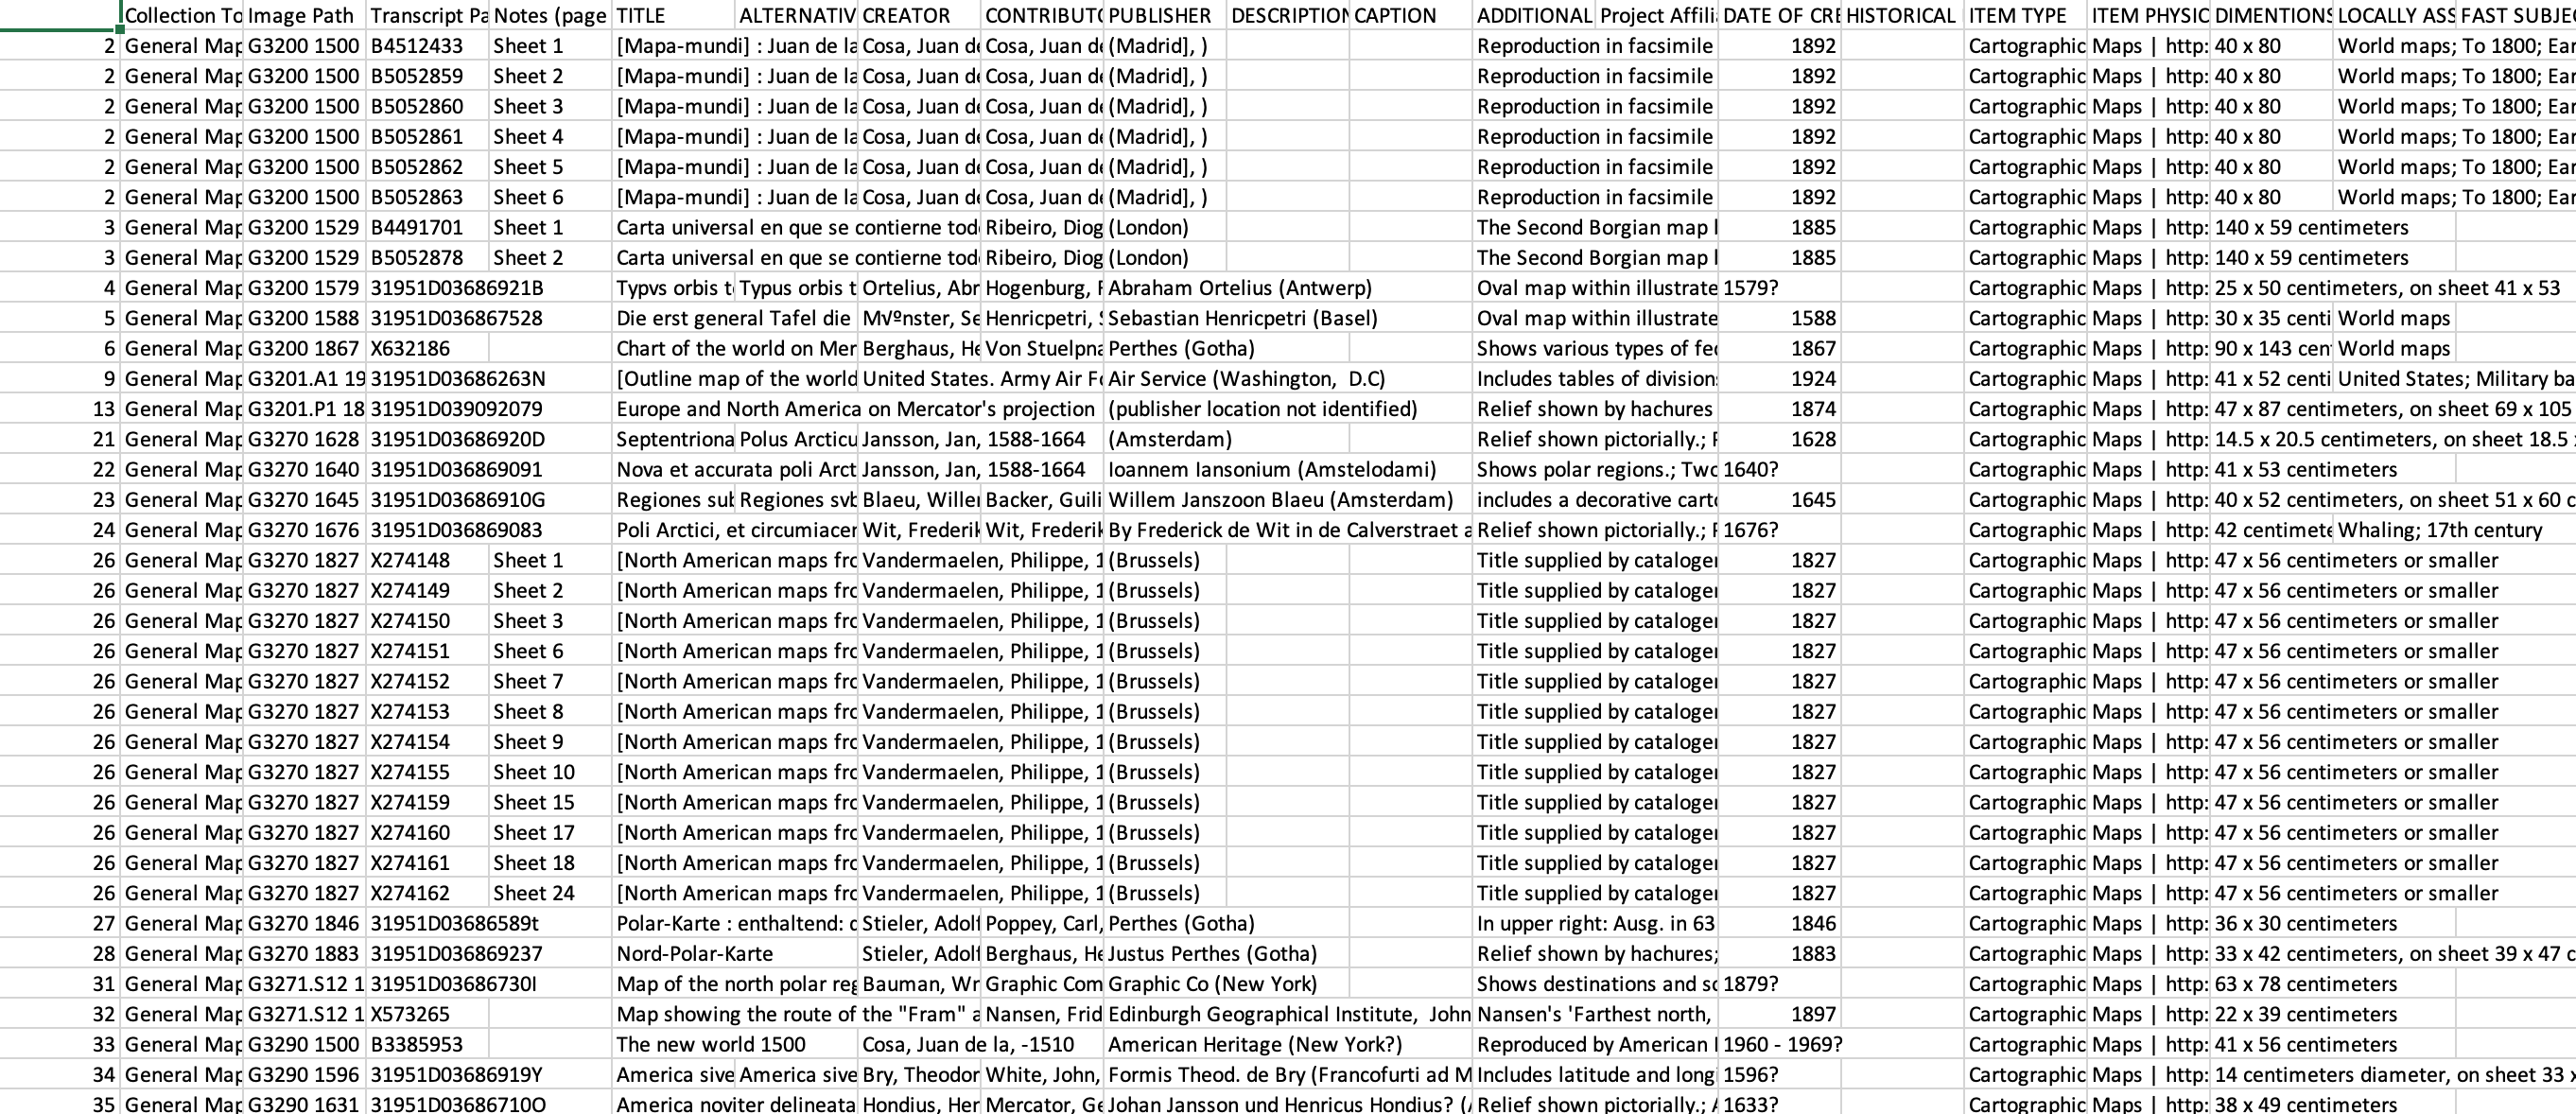Screen Shot 2023-02-06 at 16.52.29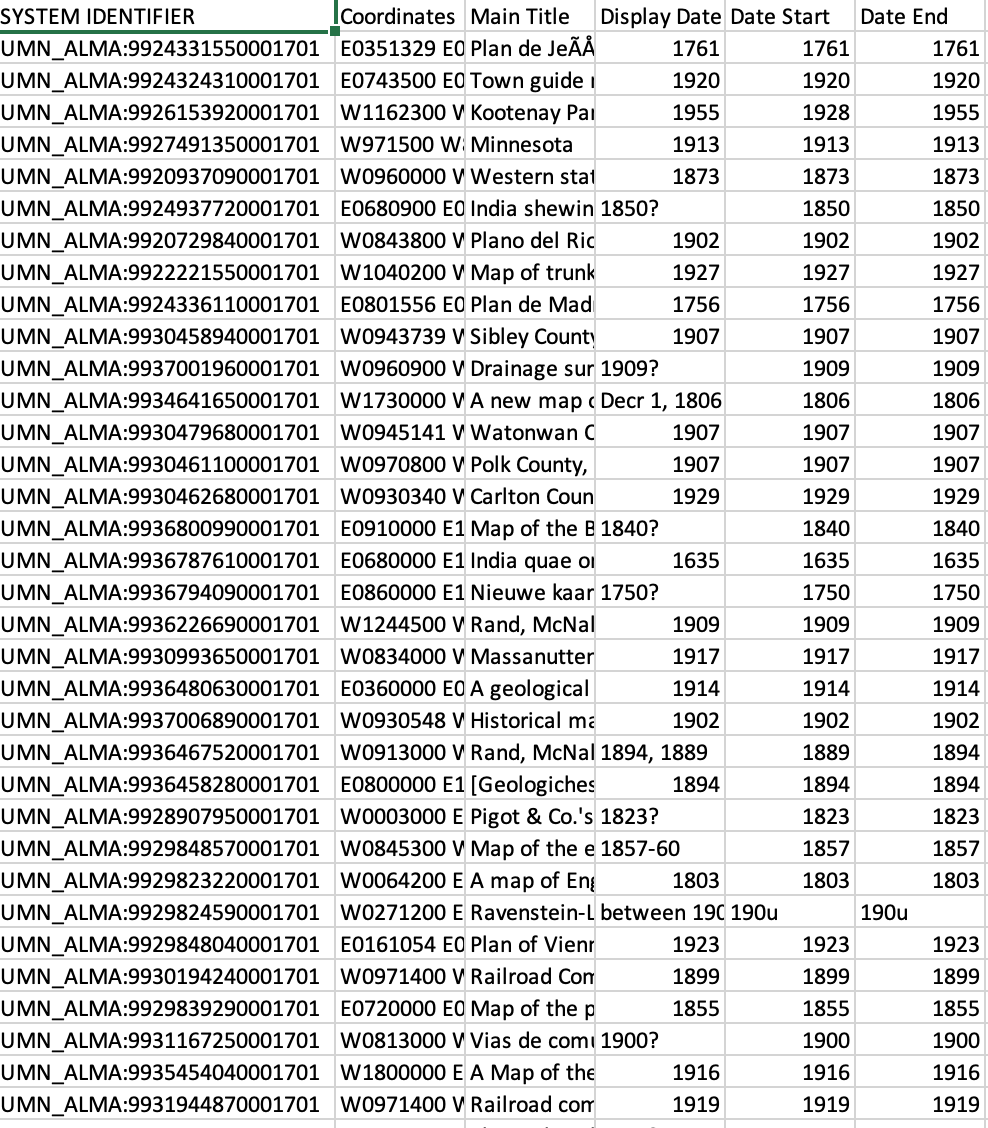

bbox_lookup.csb and bbox_lookup_2.csv contains alternative/backup records for Bounding Boxes with unqiue identifers and is predominately used with the find_bbox.ipynb Juypter Notebook in locating missing bounding boxes.

### coordSheet.csv

> https://github.com/geobtaa/workflows/blob/main/harvesting/05a-01_umedia/coordSheet.csv

Screen Shot 2023-02-07 at 19.21.08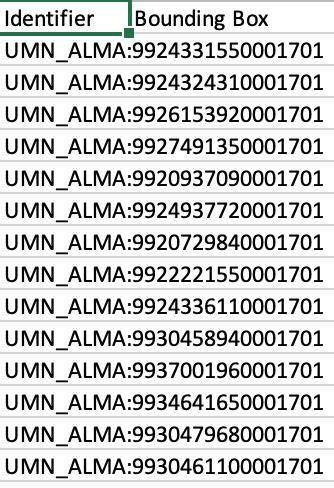

coordSheet.csv contains alternative/backup records for Bounding Boxes with unique Identifiers 

### Folders:
- **requests**

This folder stores all search results in JSON format for each reaccession as `request_YYYYMMDD.json`. 

- **jsons**

This folder stores all JSON files by different added month for UMedia maps. After we get the search result JSON file from each reaccession, we will read this `request_YYYYMMDD.json` file in detail to filter out the included maps by month, and store them to `dateAdded_YYYYMM.json` individually.

- **reports**

This folder stores all CSV files for metadata by month. Once we have JSON files for different month, we extract all useful metadata and contribute in the `dateAdded_YYYYMM.csv` in this folder.


## Google Drive

After we get the metadata CSV files from the **reports** folder, we need to upload them to the [Google Drive](https://drive.google.com/drive/u/0/folders/17ZvpFbTBPh7shYTx4m_hnP8AekqGj0wD) and do some manual edits for the **Temporal Coverage, Date Range**.


## Contributing
Pull requests are welcome. For major changes, please open an issue first to discuss what you would like to change.

### jsons folder

> https://github.com/geobtaa/workflows/tree/main/harvesting/05a-01_umedia/jsons

### reports

> https://github.com/geobtaa/workflows/tree/main/harvesting/05a-01_umedia/reports

### requests

> https://github.com/geobtaa/workflows/tree/main/harvesting/05a-01_umedia/requests